# Emulate Single Wavelength

GP emulation of 6S for a fixed wavelength.

**Author:** Brian Schubert &lt;<schubert.b@northeastern.edu>&gt;

**Date:** 22 August 2023


In [1]:
import datetime
import itertools
import math
from typing import Final

import alive_progress
import matplotlib.pyplot as plt
import numpy as np
import rtm_wrapper.parameters as rtm_param
import scipy.stats.qmc as sci_qmc
import sklearn.gaussian_process as sklearn_gp
import sklearn.pipeline
import sklearn.preprocessing as sklearn_pre
import xarray as xr
from rtm_wrapper.engines.sixs import PySixSEngine, pysixs_default_inputs
from rtm_wrapper.execution import ConcurrentExecutor
from rtm_wrapper.simulation import SweepSimulation


def unit2range(arr: np.ndarray, bot: float, top: float) -> np.ndarray:
    return arr * (top - bot) + bot

## Set wavelength and input parameter ranges

In [2]:
# Fixed wavelength to simulate.
WAVELENGTH: Final = 0.59  # micrometers

# Atmosphere parameter ranges to simulate.
OZONE_RANGE: Final = (0.25, 0.45)  # cm-atm
WATER_RANGE: Final = (1, 4)  # g/cm^2
AOT_RANGE: Final = (0.05, 0.5)  # 1
TARGET_ALT_RANGE: Final = (0.1, 30)  # km

INPUT_RANGES: Final = {
    "atmosphere.ozone": OZONE_RANGE,
    "atmosphere.water": WATER_RANGE,
    "aerosol_profile.aot": AOT_RANGE,
    # "altitude_target.value": TARGET_ALT_RANGE,
}

# Model output to emulate.
target_output: Final = "total_transmission"

## Define base 6S inputs

In [3]:
base_inputs = pysixs_default_inputs().replace(
    atmosphere=rtm_param.AtmosphereWaterOzone(),
    aerosol_profile=rtm_param.AerosolAOTSingleLayer(profile="Maritime", height=100),
    # altitude_target=rtm_param.AltitudeKilometers(),
    wavelength__value=WAVELENGTH,
)


def param_rich_name(param_name: str) -> str:
    meta = base_inputs.get_metadata(param_name)
    return f"{meta.get('title', param_name)} (${meta.get('unit', '?')}$)"

# Run true 6S simulation

## Sample atmosphere input ranges

In [4]:
# Number of LHS samples to draw.
NUM_SAMPLES: Final = 40

# Draw LHS samples.
rng = np.random.default_rng(2023_08_25)
lhs_sampler = sci_qmc.LatinHypercube(d=len(INPUT_RANGES), seed=rng)
raw_samples = lhs_sampler.random(NUM_SAMPLES)

# Draw Poisson disk samples
# pd_sampler = sci_qmc.PoissonDisk(d=2, seed=rng, radius=0.18)
# raw_samples = pd_sampler.random(NUM_SAMPLES)
# assert len(raw_samples) == NUM_SAMPLES, "failed to draw enough samples - try decreasing radius"

# Rescale LHS samples to parameter ranges.
input_samples = {
    input_name: unit2range(raw_samples[:, sample_column], *input_range)
    for sample_column, (input_name, input_range) in enumerate(INPUT_RANGES.items())
}

# Rescale LHS samples to parameter ranges.
# ozone_samples = unit2range(raw_samples[:, 0], *OZONE_RANGE)
# water_samples = unit2range(raw_samples[:, 1], *WATER_RANGE)
# # aot_samples = unit2range(raw_samples[:, 1], *AOT_RANGE)
# target_alt_samples  =unit2range(raw_samples[:, 2], TARGET_ALT_RANGE)

## Plot atmosphere input samples

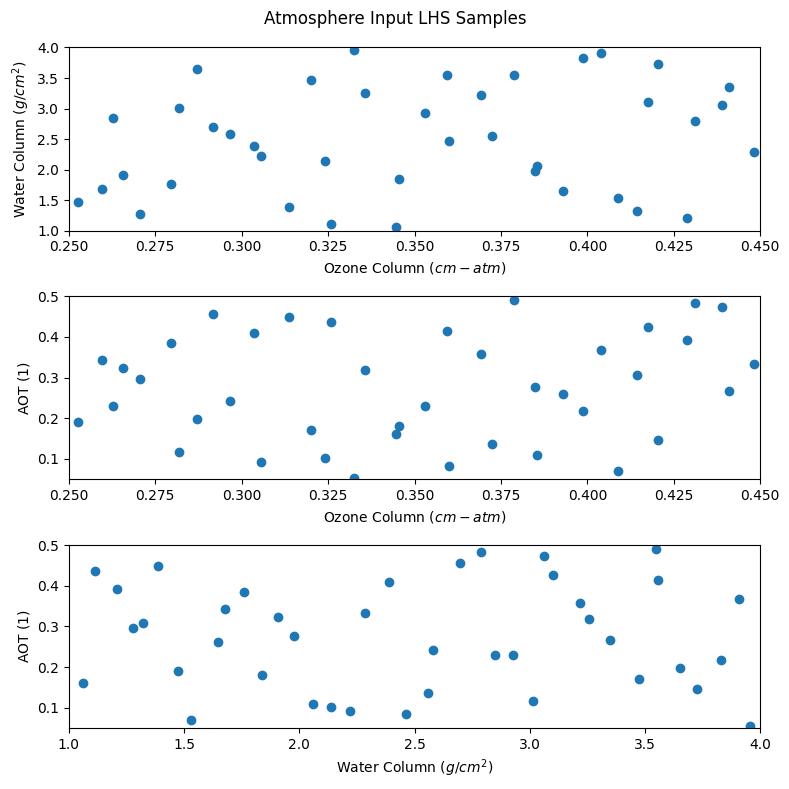

In [5]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# ax.scatter(ozone_samples, water_samples, aot_samples)

param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    ax.scatter(input_samples[param_x], input_samples[param_y])
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

fig.suptitle("Atmosphere Input LHS Samples")
fig.tight_layout()

## Perform simulation

In [6]:
sweep = SweepSimulation(
    {
        "lhs": input_samples,
    },
    base=base_inputs,
)

engine = PySixSEngine()
runner = ConcurrentExecutor(max_workers=16)

with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
    runner.run(sweep, engine, step_callback=lambda _: bar())

train_results = runner.collect_results()
train_output = train_results.data_vars[target_output]

display(train_results)

|████████████████████████████████████████| 40/40 [100%] in 2.5s (16.44/s)       


<xarray.Dataset>
Dimensions:                        (lhs: 40)
Coordinates:
  * lhs                            (lhs) int64 0 1 2 3 4 5 ... 34 35 36 37 38 39
    atmosphere.ozone               (lhs) float64 0.4142 0.4088 ... 0.3259 0.2795
    atmosphere.water               (lhs) float64 1.321 1.53 ... 1.113 1.761
    aerosol_profile.aot            (lhs) float64 0.3075 0.07093 ... 0.3847
Data variables:
    apparent_radiance              (lhs) float64 119.1 120.1 ... 120.2 118.6
    transmittance_direct_up        (lhs) float64 0.6651 0.8562 ... 0.5801 0.6125
    transmittance_scattering_down  (lhs) float64 0.924 0.9511 ... 0.9088 0.9149
    total_transmission             (lhs) float64 0.8297 0.8482 ... 0.8321 0.8231
    transmittance_diffuse_down     (lhs) float64 0.2816 0.1062 ... 0.3551 0.3275
    transmittance_scattering_up    (lhs) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    transmittance_diffuse_up       (lhs) float64 0.3349 0.1438 ... 0.4199 0.3875
    transmittance_direct_down      (lhs) float64 0.6423 0.8449 ... 0.5538 0.5874
    transmittance_total_gas        (lhs) float64 0.898 0.8918 ... 0.9155 0.8997
Attributes:
    version:     0.2.0.dev0+ab6f571
    platform:    CPython 3.10.12 (Linux atricapillus 6.2.0-26-generic #26~22....
    engine:      rtm_wrapper.engines.sixs.PySixSEngine
    base_repr:   Inputs(ground=GroundReflectanceHomogenousUniformLambertian(r...
    base_pzb64:  H4sIAMvn7GQC/1VQzUoDMRBW0FpoQZHqMyhILz6A7MUqVir+0GOY7c5uAtlk...
    sim_start:   2023-08-28T14:30:33.300748-04:00
    sim_end:     2023-08-28T14:30:35.793463-04:00

## Plot scatter of outputs at each input

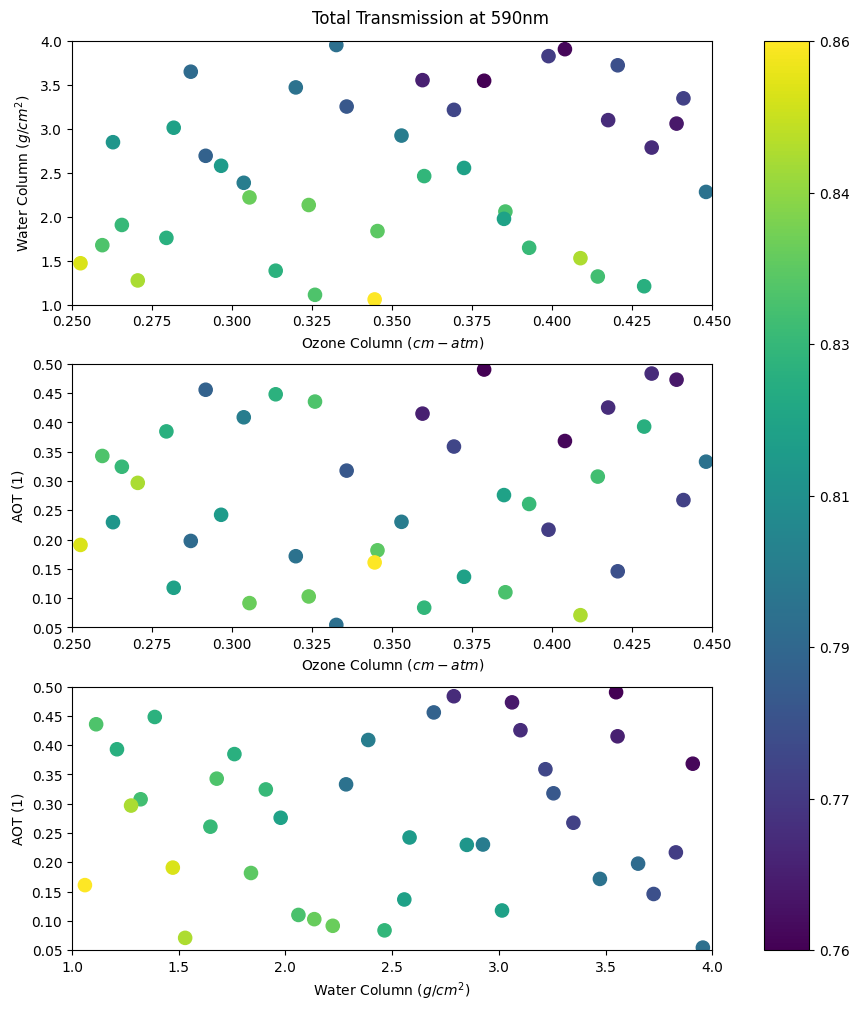

In [7]:
color_source = train_output.values
color = (color_source - color_source.min()) / (color_source.max() - color_source.min())

# fig, ax =  plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))
# art = ax.scatter(
#     train_results.coords["atmosphere.ozone"].values,
#     train_results.coords["atmosphere.water"].values,
#     train_results.coords["aerosol_profile.aot"].values,
#     c=color,
#     s=90,
#     cmap="viridis",
# )
param_combos = list(itertools.combinations(INPUT_RANGES.keys(), r=2))
ncols = math.floor(math.sqrt(len(param_combos)))
nrows = math.ceil(len(param_combos) / ncols)

fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(8.5, 10), layout="constrained"
)

for ax, (param_x, param_y) in zip(axs.flat, param_combos):
    art = ax.scatter(input_samples[param_x], input_samples[param_y], c=color, s=90)
    ax.set_xlim(INPUT_RANGES[param_x])
    ax.set_ylim(INPUT_RANGES[param_y])
    ax.set_xlabel(param_rich_name(param_x))
    ax.set_ylabel(param_rich_name(param_y))

n_ticks = 7
cbar = fig.colorbar(art, ax=axs, ticks=np.linspace(0, 1, n_ticks))
cbar.ax.set_yticklabels(
    np.round(np.linspace(color_source.min(), color_source.max(), n_ticks), 2)
)
fig.suptitle(f"{train_output.attrs.get('title', 'Output')} at {WAVELENGTH*1000:.0f}nm");

# Train Emulator

## Extract training arrays

In [8]:
x_train = np.stack(
    [train_results.coords[parameter].values for parameter in INPUT_RANGES.keys()],
    axis=-1,
)
y_train = train_output.values.reshape(-1, 1)
print(f"{x_train.shape=}, {y_train.shape=}")

x_train.shape=(40, 3), y_train.shape=(40, 1)


## Create GP model

In [9]:
kernel = 1.0 * sklearn_gp.kernels.RBF()  # + sklearn_gp.kernels.WhiteKernel()
gaussian_process = sklearn_gp.GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=20,
    alpha=1e-2,
    # alpha=1,
    # Normalize targets to zero means, unit variance.
    normalize_y=True,
)

pipeline = sklearn.pipeline.Pipeline(
    [
        # Rescale input features to [0, 1].
        ("scale", sklearn_pre.MinMaxScaler()),
        ("gp", gaussian_process),
    ]
)
display(pipeline)
display(pipeline.named_steps["gp"].kernel.hyperparameters)

Pipeline(steps=[('scale', MinMaxScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=0.01,
                                          kernel=1**2 * RBF(length_scale=1),
                                          n_restarts_optimizer=20,
                                          normalize_y=True))])

[Hyperparameter(name='k1__constant_value', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False),
 Hyperparameter(name='k2__length_scale', value_type='numeric', bounds=array([[1.e-05, 1.e+05]]), n_elements=1, fixed=False)]

## Fit model

In [10]:
pipeline.fit(x_train, y_train)
display(pipeline.named_steps["gp"].kernel_)

10.3**2 * RBF(length_scale=7.16)

## Plot marginal likelihood surface

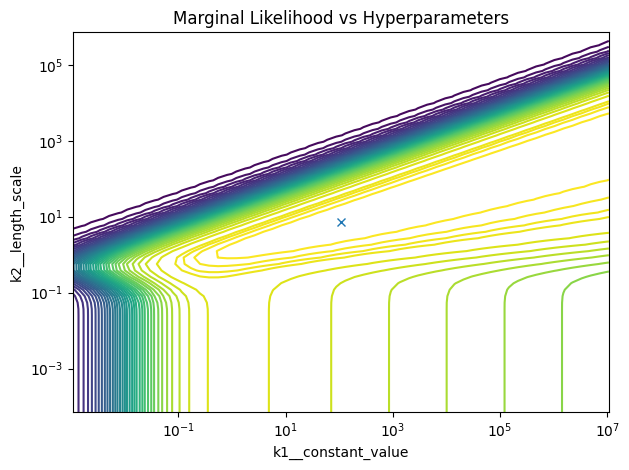

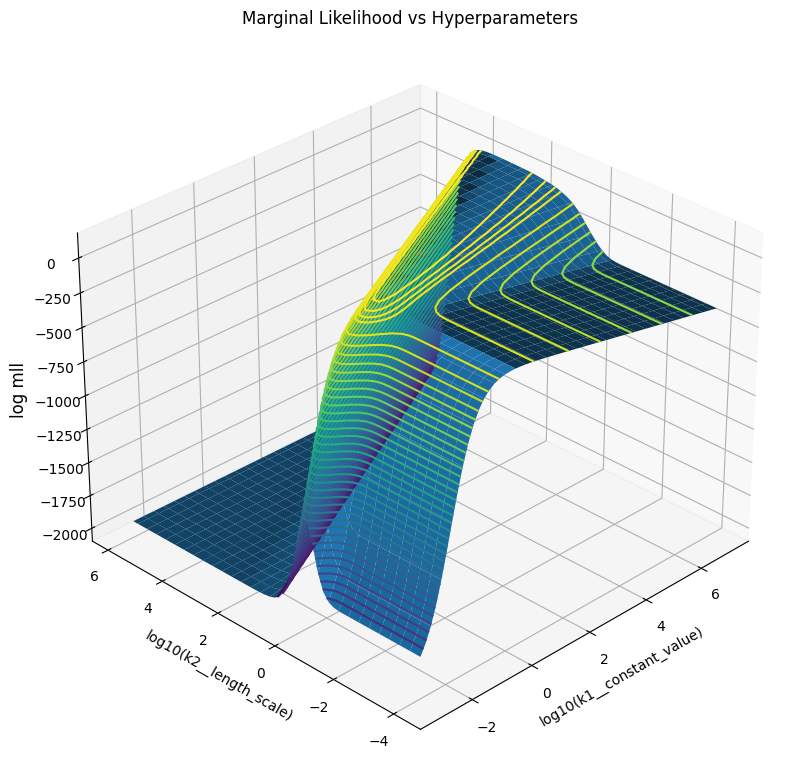

In [11]:
# Extract fit hyperparameter values.
fit_theta = pipeline.named_steps["gp"].kernel_.theta

# Indices of the two kernel hyperparameters to vary and plot MLL over.
plot_hyper_idx = [0, 1]
plot_hyper_names = [
    gaussian_process.kernel.hyperparameters[idx].name for idx in plot_hyper_idx
]

# Hyperparameter ranges to compute marginal likelihood over.
# Natural log scaled, and centered about fit hyperparameter values found above.
log_sweep_0 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[0]]
log_sweep_1 = np.log(10) * np.linspace(-5, 5, 60) + fit_theta[plot_hyper_idx[1]]


mesh_hyper_0, mesh_hyper_1 = np.meshgrid(log_sweep_0, log_sweep_1)
# Preallocate array for likelihood at each hyperparameter combination.
log_marginal_likelihoods = np.zeros(mesh_hyper_0.shape)

# Compute MLL for each hyperparameter combination.
for hyper_0, hyper_1, out in np.nditer(
    [mesh_hyper_0, mesh_hyper_1, log_marginal_likelihoods],
    op_flags=[["readonly"], ["readonly"], ["writeonly"]],
):
    theta = fit_theta.copy()
    theta[plot_hyper_idx[0]] = hyper_0
    theta[plot_hyper_idx[1]] = hyper_1
    out[...] = gaussian_process.log_marginal_likelihood(theta)

# Plot MLL contours.
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
# Pick contour levels. Increase level density near max to better show peaks.
peak_switch = np.percentile(log_marginal_likelihoods, 85)
levels = np.hstack(
    (
        np.linspace(log_marginal_likelihoods.min(), peak_switch, 40)[:-1],
        np.linspace(peak_switch, log_marginal_likelihoods.max(), 5),
    )
)
# levels = 30
art = ax.contour(
    np.exp(mesh_hyper_0), np.exp(mesh_hyper_1), log_marginal_likelihoods, levels
)
ax.plot(*np.exp(fit_theta), "x")
ax.set_xlabel(plot_hyper_names[0])
ax.set_ylabel(plot_hyper_names[1])
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Plot 3D MLL surface.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8, 8))
ax.computed_zorder = False  # Prevent surface from hiding point, https://stackoverflow.com/q/51241367/11082165
ax.view_init(elev=30, azim=-135)
zlims = ax.get_zlim()
ax.scatter(
    [fit_theta[0] / np.log(10)],
    [fit_theta[1] / np.log(10)],
    [gaussian_process.log_marginal_likelihood(fit_theta)],
    c="r",
    s=5,
    zorder=2,
)
ax.plot_surface(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    # cmap="coolwarm",
    zorder=1,
)
ax.contour(
    mesh_hyper_0 / np.log(10),
    mesh_hyper_1 / np.log(10),
    log_marginal_likelihoods,
    levels=levels,
    zorder=3,
)

ax.set_xlabel(f"log10({plot_hyper_names[0]})")
ax.set_ylabel(f"log10({plot_hyper_names[1]})")
fig.supylabel("log mll")
ax.set_title("Marginal Likelihood vs Hyperparameters")
fig.tight_layout()

# Asses Emulator

## Generate test data

In [12]:
grid_size = 10

dense_input_test = {
    param_name: np.linspace(*param_range, grid_size)
    for param_name, param_range in INPUT_RANGES.items()
}

## Obtain actual sim results for test data

In [13]:
load_results_file = None

if load_results_file is None:
    sweep = SweepSimulation(
        dense_input_test,
        base=base_inputs,
    )

    engine = PySixSEngine()
    runner = ConcurrentExecutor(max_workers=16)
    with alive_progress.alive_bar(sweep.sweep_size, force_tty=True) as bar:
        runner.run(sweep, engine, step_callback=lambda _: bar())

    test_results = runner.collect_results()
    test_results.to_netcdf(
        f"test_{grid_size}_{''.join(INPUT_RANGES.keys())}_{datetime.datetime.now().isoformat(timespec='minutes')}.nc"
    )
else:
    test_results = xr.open_dataset(load_results_file)

test_output = test_results.data_vars[target_output]
display(test_output)

|████████████████████████████████████████| 1000/1000 [100%] in 39.7s (25.24/s)  


<xarray.DataArray 'total_transmission' (atmosphere.ozone: 10,
                                        atmosphere.water: 10,
                                        aerosol_profile.aot: 10)>
array([[[0.88536686, 0.88026829, 0.87503043, 0.86970898, 0.8643318 ,
         0.85889891, 0.85343815, 0.84794954, 0.84244234, 0.83692587],
        [0.87432718, 0.86929219, 0.86411964, 0.85886454, 0.85355441,
         0.84818926, 0.8427966 , 0.83737642, 0.83193789, 0.8264902 ],
        [0.86386904, 0.85889428, 0.85378359, 0.84859135, 0.84334474,
         0.83804377, 0.8327156 , 0.82736026, 0.82198679, 0.81660426],
        [0.8539257 , 0.8490082 , 0.84395634, 0.83882387, 0.83363765,
         0.82839768, 0.82313085, 0.81783715, 0.81252553, 0.80720495],
        [0.84444951, 0.83958657, 0.83459077, 0.82951525, 0.82438659,
         0.81920478, 0.81399639, 0.80876143, 0.80350875, 0.79824722],
        [0.83540231, 0.83059148, 0.8256492 , 0.82062806, 0.81555434,
         0.81042804, 0.80527546, 0.80009658, 0.79490018, 0.78969502],
        [0.82674598, 0.821985  , 0.81709393, 0.81212482, 0.80710367,
         0.8020305 , 0.7969313 , 0.79180609, 0.78666354, 0.78151231],
        [0.81844239, 0.81372923, 0.80888728, 0.80396808, 0.79899737,
         0.79397514, 0.78892716, 0.78385343, 0.77876252, 0.77366303],
        [0.81047247, 0.8058052 , 0.80101041, 0.79613911, 0.7912168 ,
         0.78624348, 0.78124465, 0.77622033, 0.771179  , 0.76612917],
        [0.80281715, 0.79819396, 0.79344446, 0.78861917, 0.78374336,
         0.77881701, 0.77386541, 0.76888854, 0.76389482, 0.75889269]],
...
       [[0.8624581 , 0.85749146, 0.85238912, 0.84720536, 0.84196732,
         0.836675  , 0.83135554, 0.82600894, 0.82064425, 0.81527051],
        [0.85171396, 0.84680919, 0.84177041, 0.83665123, 0.83147845,
         0.82625206, 0.82099886, 0.81571887, 0.81042101, 0.80511421],
        [0.84152275, 0.83667667, 0.83169819, 0.82664026, 0.82152937,
         0.81636552, 0.81117518, 0.80595837, 0.8007239 , 0.7954806 ],
        [0.83183682, 0.82704652, 0.82212534, 0.81712562, 0.81207356,
         0.80696914, 0.80183855, 0.79668178, 0.79150756, 0.78632461],
        [0.82259895, 0.81786185, 0.81299532, 0.80805113, 0.80305517,
         0.79800744, 0.79293383, 0.78783432, 0.78271756, 0.77759217],
        [0.81379009, 0.80910372, 0.8042893 , 0.79939806, 0.7944556 ,
         0.78946192, 0.78444264, 0.77939774, 0.77433577, 0.76926527],
        [0.80535303, 0.80071524, 0.79595074, 0.79111021, 0.78621899,
         0.78127709, 0.77630984, 0.77131725, 0.76630776, 0.76128983],
        [0.79726871, 0.79267748, 0.7879608 , 0.78316886, 0.77832674,
         0.77343444, 0.76851706, 0.76357458, 0.75861538, 0.75364782],
        [0.78950852, 0.78496198, 0.78029121, 0.77554591, 0.77075092,
         0.76590625, 0.76103672, 0.75614236, 0.75123143, 0.74631222],
        [0.78204387, 0.77754031, 0.77291371, 0.76821327, 0.76346362,
         0.75866475, 0.75384127, 0.74899318, 0.74412868, 0.73925598]]])
Coordinates:
  * atmosphere.ozone     (atmosphere.ozone) float64 0.25 0.2722 ... 0.4278 0.45
  * atmosphere.water     (atmosphere.water) float64 1.0 1.333 ... 3.667 4.0
  * aerosol_profile.aot  (aerosol_profile.aot) float64 0.05 0.1 ... 0.45 0.5
Attributes:
    title:    Total Transmission
    unit:     1

## Extract test arrays

In [14]:
dense_input_meshes = np.meshgrid(
    *dense_input_test.values(),
    indexing="ij",
)

x_test = np.hstack([mesh.reshape(-1, 1) for mesh in dense_input_meshes])
y_test = test_output.values.reshape(-1, 1)

# x_test[:, 0] = 0.3  # verify axes match by making ozone constant

print(f"{x_test.shape=}, {y_test.shape=}")

x_test.shape=(1000, 3), y_test.shape=(1000, 1)


## Evaluate model on test data

In [15]:
pred_mean, pred_std = pipeline.predict(x_test, return_std=True)
pred_error = y_test - pred_mean.reshape(-1, 1)

pred_mean = pred_mean.reshape(dense_input_meshes[0].shape)
pred_std = pred_std.reshape(dense_input_meshes[0].shape)
pred_error = pred_error.reshape(dense_input_meshes[0].shape)
y_test_shaped = y_test.reshape(dense_input_meshes[0].shape)

## Compute metrics

In [16]:
rmse = np.sqrt(np.mean(pred_error**2))

abs_error = np.abs(pred_error)

print(f"RMSE: {rmse:0.2f}")
print(f"Avg abs err: {np.mean(abs_error):0.2f}")
print(f"Max abs err: {np.max(abs_error):0.2f}")
print(f"Avg rel err: {np.mean(abs_error/y_test_shaped):0.2%}")
print(f"Max rel err: {np.max(abs_error/y_test_shaped):0.2%}")

RMSE: 0.00
Avg abs err: 0.00
Max abs err: 0.00
Avg rel err: 0.11%
Max rel err: 0.45%


## Plot posterior mean, std, error

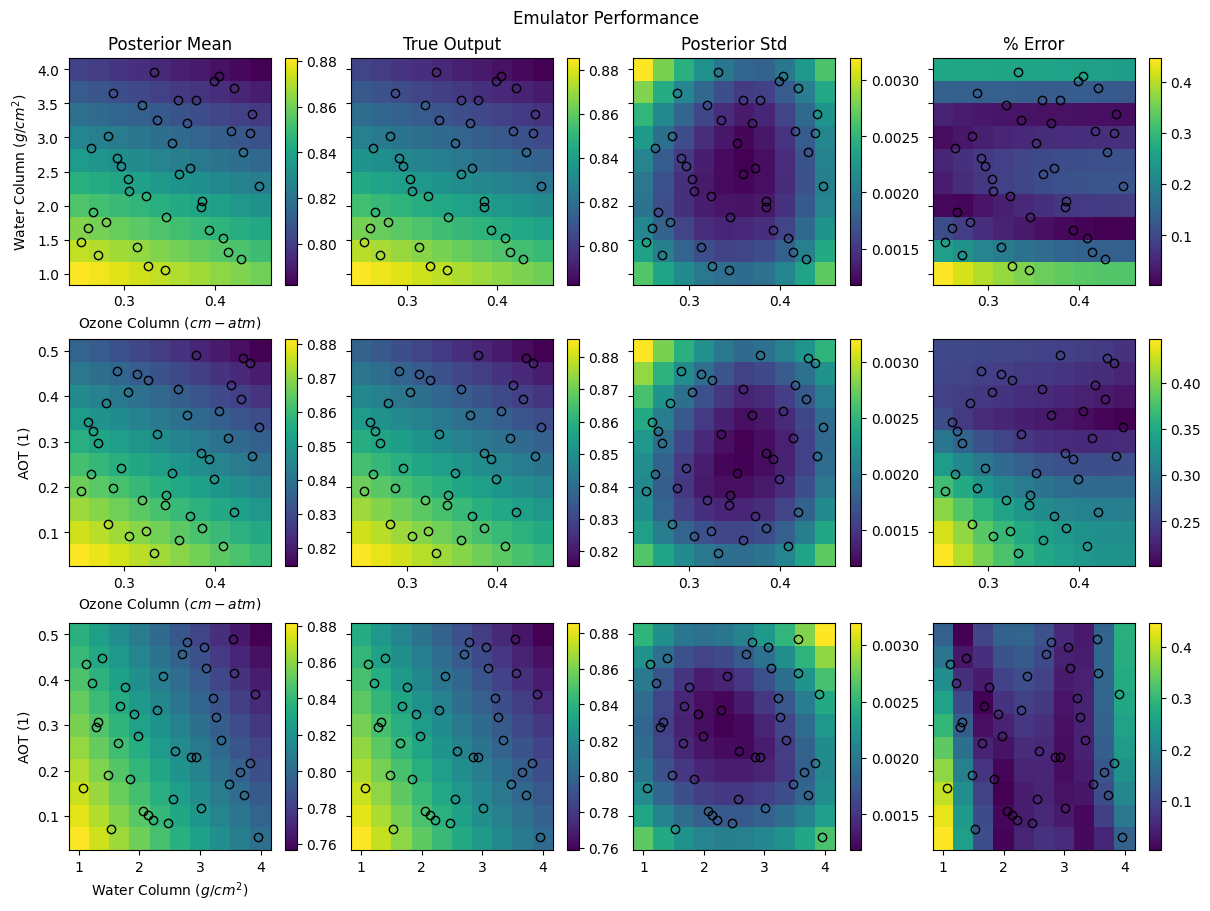

In [17]:
param_idx_combos = list(itertools.combinations(range(len(INPUT_RANGES)), r=2))
param_names = list(INPUT_RANGES.keys())
fig, axs = plt.subplots(
    nrows=len(param_combos),
    ncols=4,
    figsize=(12, 3 * len(INPUT_RANGES)),
    sharex="row",
    sharey="row",
    layout="constrained",
)


for ax_row, (param_x_idx, param_y_idx) in zip(axs, param_idx_combos):
    local_mesh_x, local_mesh_y = np.meshgrid(
        dense_input_test[param_names[param_x_idx]],
        dense_input_test[param_names[param_y_idx]],
        indexing="ij",
    )

    other_dims = tuple(
        i for i in range(len(INPUT_RANGES)) if i not in (param_x_idx, param_y_idx)
    )

    pred_mean_only = pred_mean.max(axis=other_dims)
    y_test_only = y_test_shaped.max(axis=other_dims)
    pred_std_only = pred_std.max(axis=other_dims)
    pred_error_only = pred_error.max(axis=other_dims)

    # Plot predicted mean surface.
    ax = ax_row[0]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_mean_only)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    cbar = fig.colorbar(art)

    # Plot true output surface.
    ax = ax_row[1]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, y_test_only)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    # Plot predicted variance surface.
    ax = ax_row[2]
    art = ax.pcolormesh(local_mesh_x, local_mesh_y, pred_std_only)
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    # Plot error surface.
    ax = ax_row[3]
    art = ax.pcolormesh(
        local_mesh_x, local_mesh_y, 100 * np.abs(pred_error_only) / y_test_only
    )
    ax.plot(
        input_samples[param_names[param_x_idx]],
        input_samples[param_names[param_y_idx]],
        "o",
        color="k",
        markerfacecolor="none",
    )

    fig.colorbar(art)

    ax_row[0].set_xlabel(param_rich_name(param_names[param_x_idx]))
    ax_row[0].set_ylabel(param_rich_name(param_names[param_y_idx]))

axs[0, 0].set_title("Posterior Mean")
axs[0, 1].set_title("True Output")
axs[0, 2].set_title("Posterior Std")
axs[0, 3].set_title("% Error")
fig.suptitle("Emulator Performance");